## Word embeddings

Como vimos na aula passada, construir modelos de texto pode ser muito desafiador devido à natureza não-numérica dos dados, e construir uma representação numérica adequada das strings de texto é uma das (senão a) partes mais importantes do fluxo de desenvolvimento de um modelo de texto.

Existem algumas técnicas para encontrar representações numéricas dos _tokens_ (palavras) do texto, de forma que palavras com valor semântico parecido se tornam vetores próximos em um espaço de muitas dimensões. Normalmente, essas dimensões representam, cada uma, uma "propriedade" diferente do texto, como pluralidade, pessoalidade, intensidade, positividade e etc. Estas técnicas são chamadas de _embeddings_ e apesar de serem prevalentes nos modelos de texto, também podem ser aplicadas em outros contextos. Estão no limiar entre supervisionado e não-supervisionado (o termo mais adequado é "auto-supervisionado") e podem ser construídos como uma camada de uma rede neural, "amarrando" o treino do modelo com o aprendizado do embedding relevante. É importante notar que os embeddings ficam limitados aos tokens aprendidos e podem ser extendidos para outros formatos, como imagens e áudios, criando um modelo "multimodal".

De uma forma geral, os embeddings calculam a similaridade entre palavras baseado na taxa de ocorrência destas no texto naquele contexto específico, como por exemplo, quão frequente é a palavra "pulo" em sentenças onde normalmente se esperaria também a palavra "salto" - efetivamente calculando se uma pode ser substituída pela outra.

Matematicamente, a distância entre embeddings de duas palavras é o cosseno do ângulo entre os vetores, isto é, o produto interno destes dividido pelo produto de suas normas.

<br>
<div>
    <!-- <center><img src="attachment:image.png" width='800'></center> -->
</div>

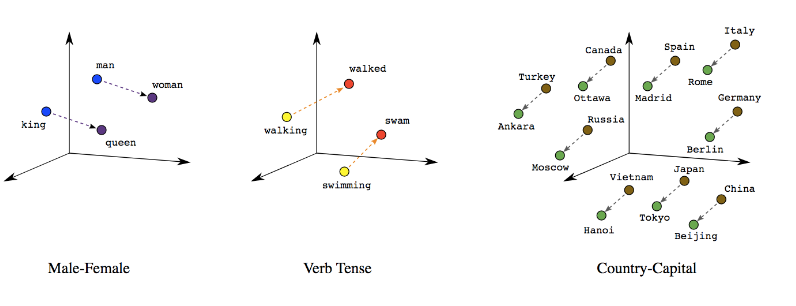

Documentação relevante (pytorch): https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html

Utilizaremos também na aula de hoje a biblioteca _Gensim_ (https://pypi.org/project/gensim/), que nos fornece algumas outras ferramentas para processamento de linguagem natural e recuperação de informações. Em específico, utilizaremos o modelo de word embeddings GloVe (https://nlp.stanford.edu/projects/glove/), pré-treinado disponibilizado no _Gensim_.

In [1]:
!pip install gensim


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Baixando modelo de embeddings pré-treinado
import gensim.downloader as dl
emb = dl.load('glove-wiki-gigaword-50')

In [3]:
emb.similar_by_vector(emb['hello'])

[('hello', 0.9999998807907104),
 ('goodbye', 0.8537959456443787),
 ('hey', 0.8074296712875366),
 ('!', 0.7951388359069824),
 ('kiss', 0.7892292737960815),
 ('wow', 0.7641353011131287),
 ('daddy', 0.7345523238182068),
 ('mama', 0.7340109944343567),
 ('bitch', 0.6982515454292297),
 ('dear', 0.6974852085113525)]

In [4]:
# queen ~= king + woman - man
dif = emb['woman'] - emb['man']
emb.similar_by_vector(emb['king'] + dif)

[('king', 0.8859834671020508),
 ('queen', 0.8609582185745239),
 ('daughter', 0.7684512734413147),
 ('prince', 0.7640699744224548),
 ('throne', 0.7634970545768738),
 ('princess', 0.7512727975845337),
 ('elizabeth', 0.7506489157676697),
 ('father', 0.7314497232437134),
 ('kingdom', 0.7296158671379089),
 ('mother', 0.728001058101654)]

In [5]:
# sushi ~= pizza + japan - italy
dif = emb['japan'] - emb['italy']
emb.similar_by_vector(emb['pizza'] + dif)

[('sushi', 0.6575174331665039),
 ('noodle', 0.6227771639823914),
 ('toy', 0.6213838458061218),
 ('snack', 0.6213502287864685),
 ('tempura', 0.6150367856025696),
 ('nippon', 0.6111320853233337),
 ('pizza', 0.6067703366279602),
 ('oyster', 0.6058492064476013),
 ('cracker', 0.5868757367134094),
 ('waffle', 0.5861366391181946)]

In [6]:
emb.similarity('queen', 'drag')

0.23699678

In [7]:
emb.similarity('queen', 'band')

0.38888836

In [8]:
emb.similarity('queen', 'monarch')

0.6773942

## Validação cruzada

Já sabemos que precisamos separar os datasets entre treino e teste para desenvolver modelos de machine learning e avaliar adequadamente seu desempenho, mas o que acontece se este corte for enviesado? Se cada vez com uma separação de treino/teste diferente o desempenho do modelo muda muito, qual é o desempenho correto?

Para resolver esse problema, podemos utilizar a técnica de _validação cruzada_ - vamos criar múltiplos subconjuntos do dataset e efetuar etapas de treino e teste de forma que todos os dados serão usados tanto para treino quanto para avaliação:

<br>
<div>
    <!-- <center><img src=attachment:image.png width="500"></center> -->
</div>




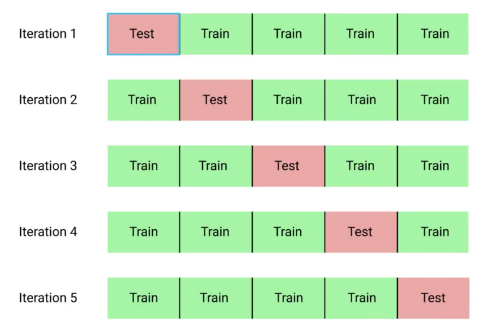

A literatura normalmente sugere quebrar em 5 ou 10 grupos, mas essa não é uma regra fixa. É importante que existam grupos suficientes para termos várias amostras do modelo, e que não tenhamos uma quantidade muito grande para não enviesar os grupos individuais nem aumentar o tempo de desenvolvimo - afinal, estaremos treinando um modelo por grupo.

Leitura sugerida: documentação da técnica no _sklearn_: https://scikit-learn.org/stable/modules/cross_validation.html

É importante notar que esta técnica não substitui completamente o _train_test_split_: na prática ainda é importante separar um pedaço do dataset como _validação_ dado que estaremos otimizando os hiperparâmetros e talvez enviesando o resultado. Os termos "test" e "validation" nesse contexto são utilizados intercambiavelmente na literatura, e a distinção importante é que um conjunto (treino) é usado para ajustar o modelo, outro conjunto (teste ou validação) é usado para avaliar a métrica de desempenho do modelo **durante a etapa de desenvolvimento** e comparar desempenhos de diferentes hiperparâmetros, e um terceiro (teste ou validação) para a avaliação final de desempenho do modelo.

In [9]:
import pandas as pd
from unidecode import unidecode
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import numpy as np
stopwords_english = stopwords.words('english')

# Recarregando o dataset
df = pd.read_csv('imdb_labelled.txt', sep='	', names=['comment', 'target_sentiment'])
# Removendo letras maiúsculas
df['comment'] = df['comment'].apply(lambda s: s.lower())
# Removendo pontuação
def remove_punct(s):
    return ''.join([c for c in s if c not in ('.', ',', '-', "'", '"', '!', '?')])
df['comment'] = df['comment'].apply(remove_punct)
# Tratando &
df['comment'] = df['comment'].apply(lambda s: s.replace('&', 'and'))

# Removendo stopwords
def remove_stopwords(s):
    global stopwords_english
    token_list = s.split(' ')
    token_list = [s for s in token_list if s not in stopwords_english]
    return ' '.join(token_list)
df['comment'] = df['comment'].apply(remove_stopwords)

# Removendo números
def remove_nums(s):
    return ''.join([c for c in s if c not in ('1234567890')])
df['comment'] = df['comment'].apply(remove_nums)

# Stemming
def stemming(s):
    stemmer = PorterStemmer()
    token_list = s.split(' ')
    token_list = [stemmer.stem(s) for s in token_list]
    return ' '.join(token_list)
df['comment'] = df['comment'].apply(stemming)

Vamos agora ajustar um modelo (Random Forest) com nosso velho amigo CountVectorizer e avaliar seu desempenho através da validação cruzada:

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
countvec = CountVectorizer()
words_matrix = countvec.fit_transform(df['comment'])
words_df = pd.DataFrame(words_matrix.todense(), columns=countvec.get_feature_names_out())
df = pd.concat([df, words_df], axis=1)
print(df.shape)

from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.3, random_state=1312)
model_cols = [c for c in df.columns if (c!='comment' and c!='target_sentiment')]

from sklearn.ensemble import RandomForestClassifier
rfr = RandomForestClassifier(n_estimators=10,
                             max_depth=10,
                             class_weight='balanced',
                             min_samples_split=10,
                             n_jobs=-1)

rfr.fit(df_train[model_cols], df_train['target_sentiment'])

from sklearn.metrics import roc_auc_score
print('ROC-AUC treino:', roc_auc_score(df_train['target_sentiment'], rfr.predict_proba(df_train[model_cols])[:,1]))
print('ROC-AUC teste:', roc_auc_score(df_test['target_sentiment'], rfr.predict_proba(df_test[model_cols])[:,1]))

(748, 2533)
ROC-AUC treino: 0.8362609970674486
ROC-AUC teste: 0.6909672830725463


In [11]:
# Calculando score de validação cruzada
from sklearn.model_selection import cross_val_score
for i in range(1, 11):
    rfr = RandomForestClassifier(n_estimators=50,
                                 max_depth=10,
                                 max_features=0.8,
                                 class_weight='balanced',
                                 min_samples_split=5,
                                 n_jobs=-1)
    scores = cross_val_score(rfr, df[model_cols], df['target_sentiment'], cv=10, scoring='roc_auc')
    print(f'Iteração {i} - ROC-AUC média cross-val: {scores.mean()}, std: {scores.std()}')

Iteração 1 - ROC-AUC média cross-val: 0.783758404153141, std: 0.05197996170203217
Iteração 2 - ROC-AUC média cross-val: 0.7884308397466292, std: 0.05636816428008909
Iteração 3 - ROC-AUC média cross-val: 0.783613269139585, std: 0.05056978351903439
Iteração 4 - ROC-AUC média cross-val: 0.7784221975011448, std: 0.05469583742298673
Iteração 5 - ROC-AUC média cross-val: 0.7836183349341244, std: 0.0562571122239465
Iteração 6 - ROC-AUC média cross-val: 0.7886499606894344, std: 0.05745082576499886
Iteração 7 - ROC-AUC média cross-val: 0.7841919095208569, std: 0.0463101216876155
Iteração 8 - ROC-AUC média cross-val: 0.7839770185164923, std: 0.053099351608358845
Iteração 9 - ROC-AUC média cross-val: 0.782595348384822, std: 0.05553480061324318
Iteração 10 - ROC-AUC média cross-val: 0.7898654727602097, std: 0.053328987078792967


## Embeddings + cross-val
Utilizando word embeddings:

In [12]:
import pandas as pd
from unidecode import unidecode
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
stopwords_english = stopwords.words('english')

# Recarregando o dataset
df = pd.read_csv('imdb_labelled.txt', sep='	', names=['comment', 'target_sentiment'])
# Removendo letras maiúsculas
df['comment'] = df['comment'].apply(lambda s: s.lower())
# Removendo pontuação
def remove_punct(s):
    return ''.join([c for c in s if c not in ('.', ',', '-', "'", '"', '!', '?')])
df['comment'] = df['comment'].apply(remove_punct)
# Tratando &
df['comment'] = df['comment'].apply(lambda s: s.replace('&', 'and'))

# Removendo stopwords
def remove_stopwords(s):
    global stopwords_english
    token_list = s.split(' ')
    token_list = [s for s in token_list if s not in stopwords_english]
    return ' '.join(token_list)
df['comment'] = df['comment'].apply(remove_stopwords)

# Removendo números
def remove_nums(s):
    return ''.join([c for c in s if c not in ('1234567890')])
df['comment'] = df['comment'].apply(remove_nums)

# Stemming
def stemming(s):
    stemmer = PorterStemmer()
    token_list = s.split(' ')
    token_list = [stemmer.stem(s) for s in token_list]
    return ' '.join(token_list)
# df['comment'] = df['comment'].apply(stemming)

In [13]:
def sentence2vec(s):
    s = s.split()
    s = [s for s in s if s in emb.index_to_key]
    try:
        embs = emb[s[0]] / len(s)
    except:
        return [np.nan]*50
    if len(s) > 1:
        for w in s[1:]:
            embs = embs + emb[w] / len(s)
    return embs

In [14]:
sentence2vec('bad terrible horrible')

array([ 0.17122667, -0.32793632, -0.48242998, -0.45288   ,  0.09470668,
        0.11806667,  0.537097  ,  0.53718   , -0.25388998,  0.27886534,
       -0.54065   ,  0.3580743 , -0.96257997, -0.23323235,  1.3934333 ,
       -0.22795   ,  0.12177167,  0.06005833, -0.23459001,  0.00259533,
       -0.52774   ,  0.43976402,  0.25526467, -0.09815   ,  0.89204997,
       -1.3118833 , -1.5313667 ,  0.49512   ,  1.7184334 , -0.15530333,
        1.9824666 ,  0.48788333,  0.50583   , -0.37739965, -0.48580664,
        0.60257334,  0.30468732, -0.39412335,  0.51940334, -0.193896  ,
       -0.85196334, -0.04197733,  0.3311833 ,  0.23632067,  0.43225002,
        0.4384033 , -0.05345566,  0.23977667,  0.70733327,  0.49867666],
      dtype=float32)

In [15]:
sentence2vec('good great awesome')

array([-0.246969  ,  0.5805    , -0.50833   , -0.06868999,  0.7394133 ,
       -0.35253668, -0.15875   ,  0.19695799,  0.01326567,  0.384718  ,
       -0.12166733,  0.5992    , -0.42088002, -0.21773933,  0.23506367,
       -0.089707  ,  0.9087    ,  0.52850336, -0.5732788 , -0.49680334,
       -0.61067665,  0.411991  , -0.16660333, -0.34046602,  1.12645   ,
       -1.25849   , -1.2047267 ,  0.02751333,  0.84138334, -0.24507335,
        2.6521666 ,  0.69819   ,  0.18404332, -0.07366566, -0.02073467,
        0.26789165, -0.05438666,  0.46770668, -0.11651666, -0.419046  ,
       -0.11919333,  0.0131394 , -0.38346332,  0.19401333, -0.10900667,
        0.25838232, -0.07865634, -0.11171335, -0.047996  ,  0.5190667 ],
      dtype=float32)

In [16]:
# Gerando embeddings
df_emb = pd.DataFrame()
for s in df['comment'].values:
    df_emb = pd.concat([df_emb, pd.DataFrame(sentence2vec(s)).T], axis=0)

In [17]:
# Juntando embeddings no dataframe original
df = pd.concat([df, df_emb.reset_index(drop=True)], axis=1)
model_cols = [str(i) for i in range(0, 50)]
df.columns = ['comment', 'sentiment'] + model_cols

In [18]:
# Dropando eventuais nulos
print(df.shape)
df.dropna(inplace=True)
print(df.shape)

(748, 52)
(747, 52)


In [19]:
from sklearn.model_selection import cross_val_score
for i in range(1, 11):
    # Instanciando modelo
    rfr = RandomForestClassifier(n_estimators=50,
                                 max_depth=10,
                                 max_features=0.8,
                                 class_weight='balanced',
                                 min_samples_split=5,
                                 n_jobs=-1)
    # Calculando score de validação cruzada
    scores = cross_val_score(rfr, df[model_cols], df['sentiment'], cv=10, scoring='roc_auc')
    print(f'Iteração {i} - ROC-AUC média cross-val: {scores.mean()}, std: {scores.std()}')

Iteração 1 - ROC-AUC média cross-val: 0.8138906619169777, std: 0.02550326880973135
Iteração 2 - ROC-AUC média cross-val: 0.813904364891207, std: 0.03051939323947748
Iteração 3 - ROC-AUC média cross-val: 0.8228161866319761, std: 0.04082878164736083
Iteração 4 - ROC-AUC média cross-val: 0.8206222416748732, std: 0.02779924403533332
Iteração 5 - ROC-AUC média cross-val: 0.8234902412533991, std: 0.0398133296615316
Iteração 6 - ROC-AUC média cross-val: 0.822310873626663, std: 0.030158980031429822
Iteração 7 - ROC-AUC média cross-val: 0.820389063152221, std: 0.03649470015130463
Iteração 8 - ROC-AUC média cross-val: 0.8229588900641532, std: 0.0359112551796257
Iteração 9 - ROC-AUC média cross-val: 0.8192046297309454, std: 0.0256863847880528
Iteração 10 - ROC-AUC média cross-val: 0.816316012368644, std: 0.03282093432982949


## Otimização de hiperparâmetros

Cada técnica de machine learning tem _parâmetros_ que são ajustados aos dados - no caso da regressão linear, por exemplo, os parâmetros são os coeficientes multiplicados em cada feature. Os modelos também possuem normalmente _hiperparâmetros_, que são variáveis de inicialização e controlam a etapa de ajuste do modelo, como por exemplo a quantidade de árvores na _random forest_.

Dessa forma, como podemos descobrir os melhores hiperparâmetros dado um problema e uma técnica? Um dos possíveis jeitos é simplesmente testar várias combinações possíveis. O _sklearn_ possui uma ferramenta para essa finalidade também, já incorporada com o _cross validation_:

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.3, random_state=1312)
model_cols = [c for c in df.columns if (c!='comment' and c!='sentiment')]

# Instanciando estimador
rfr = RandomForestClassifier()

# Instanciando lista de parâmetros para testar
params = {'n_estimators':[10, 20, 40, 60, 100, 200, 300],
          'max_depth':[3, 4, 6, 8, 10, 15],
          'class_weight':['balanced'],
          'min_samples_split':[3, 5, 10, 20, 50]}



rfr_gs = GridSearchCV(RandomForestClassifier(),
                      param_grid=params,
                      scoring='roc_auc',
                      cv=5)

rfr_gs.fit(df_train[model_cols], df_train['sentiment'])
rfr_gs.best_params_

{'class_weight': 'balanced',
 'max_depth': 15,
 'min_samples_split': 10,
 'n_estimators': 300}

In [21]:
for i in range(1, 6):
    rfr = RandomForestClassifier(n_estimators=200,
                                 max_depth=10,
                                 max_features=0.8,
                                 class_weight='balanced',
                                 min_samples_split=3,
                                 n_jobs=-1)

    scores = cross_val_score(rfr, df[model_cols], df['sentiment'], cv=10, scoring='roc_auc')
    print(f'Iteração {i} - ROC-AUC média cross-val: {scores.mean()}, std: {scores.std()}')

Iteração 1 - ROC-AUC média cross-val: 0.8280171365697682, std: 0.030815296703003668
Iteração 2 - ROC-AUC média cross-val: 0.8318840095155885, std: 0.02786238596418682
Iteração 3 - ROC-AUC média cross-val: 0.8275245893666945, std: 0.0265408901305393
Iteração 4 - ROC-AUC média cross-val: 0.8288464577938262, std: 0.028111310481724675
Iteração 5 - ROC-AUC média cross-val: 0.8282166782166783, std: 0.03136366839465149


## Exercícios
- Avalie o desempenho (ROC-AUC) no conjunto de teste de uma random forest ajustada com os melhores hiperparâmetros encontrados
- Explorar _todas_ as combinações de hiperparâmetros pode ser muito custoso computacionalmente e não executar em tempo hábil. Há jeitos mais inteligentes de fazer essa busca, como procurar aleatoriamente (ao invés de explorar todas as combinações), como no _RandomizedSearchCV()_ do _sklearn_. Implemente essa busca aleatória explorando mais hiperparâmetros do que os utilizados no GridSearchCV(). Documentação: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html

##### Sugestão
- Os embeddings podem dar alguns resultados surpreendentes. Escolha alguns termos específicos e explore palavras similares no embedding; tente encontrar diferenças entre palavras e usar essas diferenças para encontrar outras palavras. Dica: `dir(emb)` exibirá todos os métodos e atributos do objeto `emb`.

##### Desafio
- Há um jeito ainda melhor de otimizar os hiperparâmetros utilizando técnicas estatísticas. Uma ótima biblioteca para isso é o _Optuna_ (https://optuna.org/#code_examples). Implemente uma busca de hiperparâmetros com essa biblioteca e compare o desempenho e os hiperparâmetros encontrados com o GridSearchCV. A implementação do Optuna é um pouco mais verbosa.